Import the required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
#from torchtext.legacy.datasets import Multi30k

from torchtext.legacy.data import Field, BucketIterator

import spacy
import numpy as np
import pandas as pd
import torch.nn.functional as F

import random
import math
import time

import gzip
import shutil
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline

set a seed to enable repeatability of model operation

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
!pip install spacy --upgrade

Requirement already up-to-date: spacy in /usr/local/lib/python3.7/dist-packages (3.0.6)


### download the spacy english vocabulary 

In [ ]:
%%bash
python -m spacy download en


⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-06-24 04:29:44.591413: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


restart the notebook before running this step

In [ ]:
spacy_en = spacy.load('en_core_web_sm')


### helper function to tokenize english sentence

In [ ]:
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Unpack the question answer zip file

https://nlp.cs.washington.edu/ambigqa/

In [ ]:
shutil.unpack_archive('/content/nqopen.zip','/content/nqopen')

### Walk through the unpacked folders

* find **nqopen-dev/test/train.json** file
* there are 3 columns in the file
   * id
   * question
   * answer 
* load the json file to a dataframe

In [ ]:
dflist = []
for root, dirs, files in os.walk('/content/nqopen'):
  print(dirs , files )
  for f in files:
    if f.endswith('.json'):
      path = os.path.join(root,f)
      #print(path)
      df = pd.read_json(path)
      #print(df.head())
      dflist.append(df)
dfchat = pd.concat(dflist,ignore_index=True)
dfchat.head()


[] ['nqopen-train.json', 'nqopen-test.json', 'nqopen-dev.json', 'LICENSE']


,id,question,answer
0,-6802534628745606144,total number of death row inmates in the us,"[2,718]"
1,-8178292525996414976,big little lies season 2 how many episodes,[seven]
2,1727798345024846336,who sang waiting for a girl like you,[Foreigner]
3,-1862942322519208448,where do you cross the arctic circle in norway,[Saltfjellet]
4,-6742567993987507200,who is the main character in green eggs and ham,[Sam - I - am]


##### The answer column is a list object , convert that to string

In [ ]:
dfchat['answer'] = dfchat.answer.apply(lambda x: ' '.join(x) )

dfchat.head()

,id,question,answer
0,-6802534628745606144,total number of death row inmates in the us,"2,718"
1,-8178292525996414976,big little lies season 2 how many episodes,seven
2,1727798345024846336,who sang waiting for a girl like you,Foreigner
3,-1862942322519208448,where do you cross the arctic circle in norway,Saltfjellet
4,-6742567993987507200,who is the main character in green eggs and ham,Sam - I - am


### drop rows from the dataframe where answer is NULL

In [ ]:
notnull_answerDF = dfchat[dfchat['answer'] != 'NULL']
len(notnull_answerDF  ) , len (dfchat)

(91535, 91535)

### Create a new dataframe object with only 2 columns 

* Question
* Answer

In [ ]:
data=[notnull_answerDF['question'],notnull_answerDF['answer']]

headers = ["question", "answer"]

qa_data = pd.concat(data, axis=1, keys=headers)
qa_data.head()

,question,answer
0,total number of death row inmates in the us,"2,718"
1,big little lies season 2 how many episodes,seven
2,who sang waiting for a girl like you,Foreigner
3,where do you cross the arctic circle in norway,Saltfjellet
4,who is the main character in green eggs and ham,Sam - I - am


### dump the dataframe to a file

In [ ]:
qa_data.to_csv('ambigqadata.tsv', sep = '\t', index=False)

### Upload the question and answer dataset and store in a dataframe


In [ ]:
qadf = pd.read_csv("/content/ambigqadata.tsv", sep='\t')

### Check if there are NaN in Answer

In [ ]:
an = qadf [qadf.answer.isnull() == True]
an

,question,answer


In [ ]:
qadf.isna().any(axis=None)

False

### replace NaN with empty string

In [ ]:
qadf = qadf.fillna('') #, inplace=True)

In [ ]:
qadf.head()

,question,answer
0,total number of death row inmates in the us,"2,718"
1,big little lies season 2 how many episodes,seven
2,who sang waiting for a girl like you,Foreigner
3,where do you cross the arctic circle in norway,Saltfjellet
4,who is the main character in green eggs and ham,Sam - I - am


### double check if there are anymore NaN in answer

In [ ]:
an = qadf [qadf.answer.isnull() == True]
an

,question,answer


### Create torchtext.legacy.data Field object for source question and target answer

In [ ]:
SRC = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>') #, 
            #lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>') #, 
            #lower = True)

The fields created above are mapped from column headers

| Column header | Variable name |
| --- | --- |
| **question** | SRC |
| **answer** | TRG |

In [ ]:
fields = [('question', SRC), ('answer', TRG)]

#### torchtext example object is created from the dataframe object

* using 2 columns from dataframe - question , answer
* column header created above

In [ ]:
example = [torchtext.legacy.data.Example.fromlist([qadf.question[i],qadf.answer[i]], fields) for i in range(qadf.shape[0])] 

#### torchtext dataset is created

* using example and column header created above

In [ ]:
qaDataset = torchtext.legacy.data.Dataset(example, fields)

### The dataset is split into train and test in the raio of 70:30

In [ ]:
(train, test) = qaDataset.split(split_ratio=[70, 30] , random_state = random.seed(SEED) )

a sample record from train dataset

In [ ]:
vars(train.examples[15])

{'answer': ['land', 'labour', 'capital'],
 'question': ['what',
  'are',
  'the',
  'three',
  'main',
  'factors',
  'of',
  'production']}

#### count of train and test dataset

* **64074** train records
* **27461** test records

In [ ]:
print(f"Number of training examples: {len(train.examples)}")
print(f"Number of testing examples: {len(test.examples)}")

Number of training examples: 64074
Number of testing examples: 27461


In [ ]:
vars(train.examples[0])

{'answer': ['James', 'Callis'],
 'question': ['who',
  'played',
  'haman',
  'in',
  'one',
  'night',
  'with',
  'the',
  'king']}

### Build vocabulary of 

* train text for the SRC and TRG field

In [ ]:
SRC.build_vocab(train, min_freq = 2)
TRG.build_vocab(train, min_freq = 2)

In [ ]:
print(f"Unique tokens in source (en) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (en) vocabulary: 13655
Unique tokens in target (en) vocabulary: 15034


### Dump the SRC and TRG vocabulary for later use

In [ ]:
import os, pickle
with open('srctokenizer.pkl', 'wb') as srctokens: 
    pickle.dump(SRC.vocab.stoi, srctokens)

with open('trgtokenizer.pkl', 'wb') as trgtokens: 
    pickle.dump(TRG.vocab.stoi, trgtokens)    

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Create train and test iterator using BucketIterator

* Sort key is set on question - the source

In [ ]:
BATCH_SIZE = 128

train_iterator, test_iterator = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size = BATCH_SIZE, 
                                                            sort_key = lambda x: len(x.question),
                                                            sort_within_batch=True, device = device)




### Encoder class

There are 3 layers in the encoder

* Embedding layer which stores the vocabulary of question 1

* LSTM layer to process the sentence and return the hidden and cell state

* Dropout layer for regularization

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        #self.rnn = nn.LSTMCell(hidden_dim, hidden_dim)

        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src , hidden, cell):

        #src = [src len, batch size]
        src = src.unsqueeze(0)
        embedded = self.dropout(self.embedding(src))
        
        #print(embedded.shape , hidden.shape, cell.shape)

        outputs, (hidden, cell) = self.rnn(embedded,( hidden, cell))
        
        #outputs = [src len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell

### Decoder class

There are 4 layers in the decoder

* Embedding layer which stores the vocabulary of answer

* LSTM layer to process the TRG sentence and return the output

* LSTM layer to process the context vector returned by attention mechanism and the hidden state and cell state returned by the above lstm layer and return the output

* Linear layer to process the output returned by LSTM and generate a 1D vector having the size of TRG vocabulary

* Dropout layer for regularization

This class returns 1D vector of prediction and the last hidden and cell state

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn_encd = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.rnn_dcd = nn.LSTM(hid_dim, hid_dim, n_layers, dropout = dropout)
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input,context, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        context = context.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        #print(input.shape , embedded.shape)       

        _ , (hidden, cell) = self.rnn_encd(embedded, (hidden, cell))
        
        output, (hidden, cell) = self.rnn_dcd(context, (hidden, cell))
        

        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### seq2seq class

**Attention mechanism:** An attention mechanism is added in seq2seq class

  * The last hidden state of the decoder is paired with each hidden state of the encoder.

  * Each pair is passed to a linear layer  to get the weight for that word

  * All the weights are then stacked vertically and reshaped to get the relative weight of each word w.r.t the sentence using a softmax function.

  * The relative weight vector is multiplied with the singlevector generated by the encoder to get the **Context vector** of the word w.r.t the sentence.

This is a wrapper class to call the encoder and decoder class 

* Each word of the source sentence is supplied to the encoder and the hidden and cell state are stacked to return a single vector for hidden and cell state.

* This single vector along with the last hidden and cell state is provided to the attention mechanism , which returns a context vector

* In each iterations one word at a time is supplied till the end of the sentence along with the context vector, previous hidden and cell state.

* The output of each iteration is stored in an array

* In addition a threshhold limit is set to decide whether to pick the max from the output returned by the decoder or the next word of the sentence in the next iteration.

* The loop continues till the end

* The array of output is returned by the seq2seq model


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.attentionfc = nn.Linear(decoder.hid_dim*2, 1)

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def attention(self, decoderhidden, singlevector,batchsize, seqlen):

        #print('atn sv', seqlen ,singlevector.size())
        attention = []
        for i in range(seqlen):
          #print(decoderhidden.shape , singlevector[i].shape)
          attentionhidden = torch.cat((decoderhidden.squeeze(0),singlevector[i]),1)
          #attentionhidden = attentionhidden.to(device)
          #print(attentionhidden.size())
          attentionout = self.attentionfc(attentionhidden)
          attention.append(attentionout)
          
        tup_attention = tuple(a for a in attention)
        attentionvstack = torch.vstack(tup_attention)
        attentionvector = attentionvstack.reshape(batchsize, seqlen)
        attentionvector = attentionvector.unsqueeze(1)

        alpha = F.softmax(attentionvector , dim=1)
        
        reshapedsinglevector = singlevector.reshape(batchsize, seqlen , self.encoder.hid_dim)
        #print('alp',alpha.size() , reshapedsinglevector.size())
        
        context = torch.bmm(alpha,reshapedsinglevector)

        context = context.squeeze(1)

        return context



    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        src_batch_size = src.shape[1]
        src_len = src.shape[0]

        hidden_encoders = torch.zeros(src_len, src_batch_size, self.encoder.hid_dim).to(self.device)
        cell_encoders = torch.zeros(src_len, src_batch_size, self.encoder.hid_dim).to(self.device)

        # Initialization of hidden state and cell state for LSTMCell
        hidden = torch.zeros(self.encoder.n_layers,src.size(1), self.encoder.hid_dim)
        cell = torch.zeros(self.encoder.n_layers,src.size(1), self.encoder.hid_dim)

        # Weights initialization
        torch.nn.init.xavier_normal_(hidden)
        torch.nn.init.xavier_normal_(cell)
        #print(text_lengths)

        #hidden = hidden.unsqueeze(0) 
        #cell = cell.unsqueeze(0)

        hidden , cell = hidden.to(device) , cell.to(device) 

        for t in range(src_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            hidden, cell = self.encoder(src[t], hidden, cell)
            #print(src.shape , hidden.shape,cell.shape,hidden_encoders.shape,cell_encoders.shape)
            #place predictions in a tensor holding predictions for each token
            hidden_encoders[t] = hidden
            cell_encoders[t] = cell

        #print(hidden_encoders.shape)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        #hidden, cell = self.encoder(src)
        #print(hidden.shape)
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            contextvector = self.attention(hidden, hidden_encoders, batch_size, src_len)
            #print(contextvector.shape)
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input , contextvector, hidden, cell)
            #output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

### Initialize 

* the hyperparameters

* create encoder and decoder instance

* create instance of seq2seq model

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = 512
N_LAYERS = 1
ENC_DROPOUT = 0.7
DEC_DROPOUT = 0.7

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Initialize the weights

* apply the weights to the model

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(13655, 512)
    (rnn): LSTM(512, 512, dropout=0.7)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(15034, 512)
    (rnn_encd): LSTM(512, 512, dropout=0.7)
    (rnn_dcd): LSTM(512, 512, dropout=0.7)
    (fc_out): Linear(in_features=512, out_features=15034, bias=True)
    (dropout): Dropout(p=0.7, inplace=False)
  )
  (attentionfc): Linear(in_features=1024, out_features=1, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 28,705,979 trainable parameters


### create an instance of Adam optimizer

In [ ]:
optimizer = optim.Adam(model.parameters())

### Create an instance of CrossEntropyLoss

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

### utility function to train the model

* extract question 1 and question 2 from the batch object and pass it on to model

* reshape the output and calculate the loss between the predicted output question and target answer 

* aggregate the loss per epoch

* back propagate to adjust the model weights


In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for batch in iterator:
        
        src = batch.question #src
        trg = batch.answer #trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### utility function to evaluate the model

* set the model in evaluation mode and no back propagation

* extract question and answer from the batch object and pass it on to model

* reshape the output and calculate the loss between the predicted output answer and target answer 

* aggregate the loss per epoch

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for batch in iterator:

            src = batch.question # src
            trg = batch.answer #trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### run the model on train and test data for 10 epochs

the model was run for 10 epochs

* the best model weight was saved for evaluating the model


In [ ]:
N_EPOCHS = 10
CLIP = 1
trainLossList = []
valLossList = []

trainAccyList = []
valAccyList = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    trainLossList.append(round(train_loss,2))
    valLossList.append(round(valid_loss,2))

    trainAccyList.append(round(math.exp(train_loss),2))
    valAccyList.append(round(math.exp(valid_loss),2))


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 1m 47s
	Train Loss: 5.792 | Train PPL: 327.590
	 Val. Loss: 5.072 |  Val. PPL: 159.415
Epoch: 02 | Time: 1m 47s
	Train Loss: 5.127 | Train PPL: 168.591
	 Val. Loss: 4.800 |  Val. PPL: 121.560
Epoch: 03 | Time: 1m 48s
	Train Loss: 4.820 | Train PPL: 123.929
	 Val. Loss: 4.700 |  Val. PPL: 109.999
Epoch: 04 | Time: 1m 47s
	Train Loss: 4.556 | Train PPL:  95.232
	 Val. Loss: 4.579 |  Val. PPL:  97.396
Epoch: 05 | Time: 1m 48s
	Train Loss: 4.279 | Train PPL:  72.165
	 Val. Loss: 4.492 |  Val. PPL:  89.316
Epoch: 06 | Time: 1m 47s
	Train Loss: 4.017 | Train PPL:  55.517
	 Val. Loss: 4.439 |  Val. PPL:  84.651
Epoch: 07 | Time: 1m 48s
	Train Loss: 3.766 | Train PPL:  43.225
	 Val. Loss: 4.412 |  Val. PPL:  82.432
Epoch: 08 | Time: 1m 47s
	Train Loss: 3.528 | Train PPL:  34.050
	 Val. Loss: 4.401 |  Val. PPL:  81.541
Epoch: 09 | Time: 1m 47s
	Train Loss: 3.302 | Train PPL:  27.166
	 Val. Loss: 4.396 |  Val. PPL:  81.135
Epoch: 10 | Time: 1m 46s
	Train Loss: 3.074 | Train PPL

### A graph of model performance 

1.   Training and testing PPL across different epochs
2.   Training and testing loss across different epochs



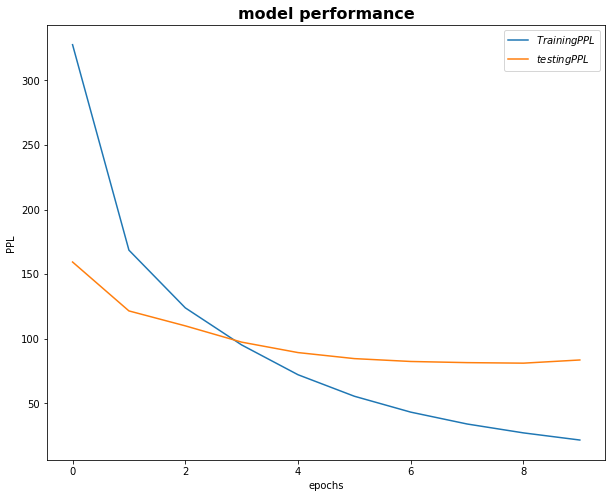

In [ ]:
xpoints = np.arange(len(trainLossList))
ypoints4 = trainAccyList
ypoints6 = valAccyList

plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(xpoints, ypoints4, label = "$ Training PPL $" )
plt.plot(xpoints, ypoints6, label = "$ testing PPL $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("PPL ")
plt.show()

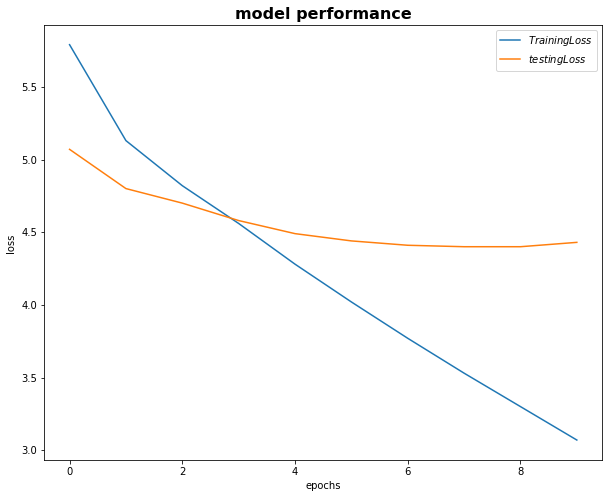

In [ ]:
xpoints = np.arange(len(trainLossList))
ypoints0 = trainLossList
ypoints2 = valLossList


plt.rcParams['figure.figsize'] = [10,8]
plt.plot(xpoints, ypoints0 , label = "$ Training Loss $" )
plt.plot(xpoints, ypoints2, label = "$ testing Loss $" )

plt.legend(loc="upper right")

plt.title("model performance", fontsize=16, fontweight='bold')
plt.xlabel("epochs")
plt.ylabel("loss ")
plt.show()

### Utility function to test a single pair of Question and Answer

In [ ]:
#load weights and tokenizer

#path='./saved_weights.pt'
#model.load_state_dict(torch.load(path));

model.eval();
srctokenizer_file = open('./srctokenizer.pkl', 'rb')
srctokenizer = pickle.load(srctokenizer_file)

trgtokenizer_file = open('./trgtokenizer.pkl', 'rb')
trgtokenizer = pickle.load(trgtokenizer_file)


#inference 
#categories = {0: "Negative", 1:"Positive", 2:"Neutral"}

import spacy
nlp = spacy.load('en_core_web_sm')

def answer_question(question , answer):
    
    
    
    # tokenize the tweet 
    srctokenized = [tok.text for tok in nlp.tokenizer(question)] 
    #print(tokenized)
    # convert to integer sequence using predefined tokenizer dictionary
    srcindexed = [srctokenizer[t] for t in srctokenized] 
    #print(indexed)       
    # compute no. of words        
    #length = [len(indexed)]
    # convert to tensor                                    
    srctensor = torch.LongTensor(srcindexed).to(device)   
    #print(tensor)
    # reshape in form of batch, no. of words           
    srctensor = srctensor.unsqueeze(1).T  
    #print(tensor)

    # tokenize the tweet 
    trgtokenized = [tok.text for tok in nlp.tokenizer(answer)] 
    #print(tokenized)
    # convert to integer sequence using predefined tokenizer dictionary
    trgindexed = [trgtokenizer[t] for t in trgtokenized] 
    #print(indexed)       
    # compute no. of words        
    #length = [len(indexed)]
    # convert to tensor                                    
    trgtensor = torch.LongTensor(trgindexed).to(device)   
    #print(tensor)
    # reshape in form of batch, no. of words           
    trgtensor = trgtensor.unsqueeze(1).T  



    # convert to tensor                          
    #length_tensor = torch.LongTensor(length)
    #print(length_tensor)
    # Get the model prediction                  
    prediction = model(srctensor, trgtensor)
    print(srctensor.shape , trgtensor.shape )
    output_dim = prediction.shape[-1]
    print(output_dim , prediction.size())
            
    output = prediction.squeeze(0)
    #output = output.squeeze(0)
    print(output)
    _, pred = torch.max(output, 1) 
    print(pred.size(),pred)
    
    return pred #.item()

### Test a question

In [ ]:
qst = 'who played in the most world series games'
ans =  'the New York Yankees'
print(answer_question(qst , ans))

torch.Size([1, 8]) torch.Size([1, 4])
15034 torch.Size([1, 4, 15034])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
torch.Size([4]) tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')


## Diagnostics

The model was run several times with different dropout values , a plot of the model performance across these runs is shown below.


In [ ]:
diagnosticDict = {}

diagnosticDict['embeddeddim'] = ENC_EMB_DIM
diagnosticDict['hiddendim'] = HID_DIM
diagnosticDict['epochs'] = N_EPOCHS
diagnosticDict['dropout'] = ENC_DROPOUT
diagnosticDict['batchsize'] = BATCH_SIZE
diagnosticDict['trainLossList'] = trainLossList
diagnosticDict['valLossList']= valLossList
diagnosticDict['trainAccyList'] = trainAccyList
diagnosticDict['valAccyList'] = valAccyList


#diagnosticDict

In [ ]:
import json

with open("ambigqa_lstmdiagnostic.json", "a") as out_file:
  json.dump(diagnosticDict, out_file, indent = 6)


In [ ]:
with open('./allambigqa_lstmdiagnostic.json') as f:
  data = json.load(f)
  #print(data)


utility function to plot diagnostic information

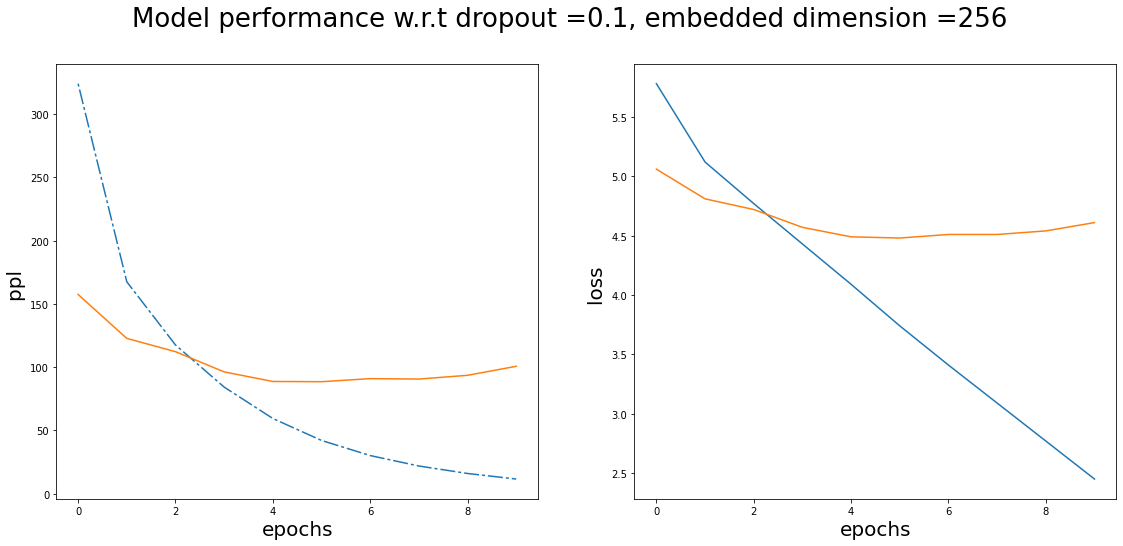

11.57 100.7 2.45 4.61


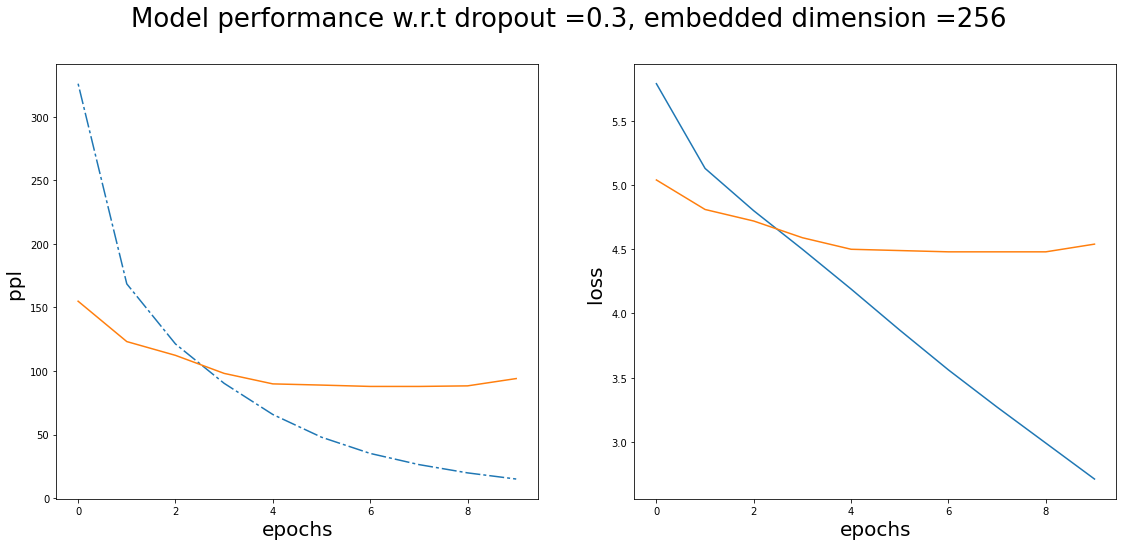

15.02 94.07 2.71 4.54


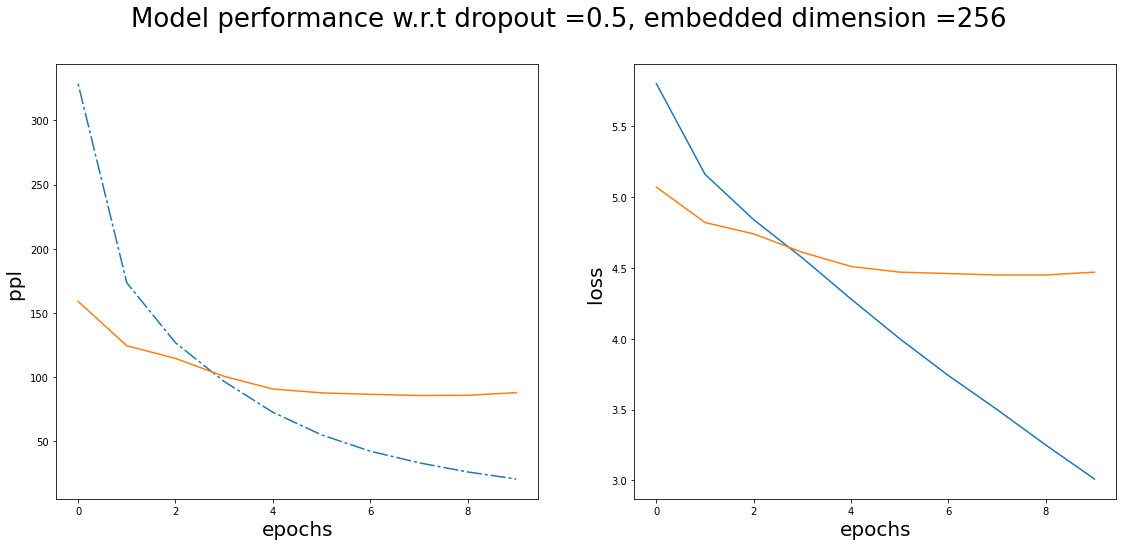

20.33 87.69 3.01 4.47


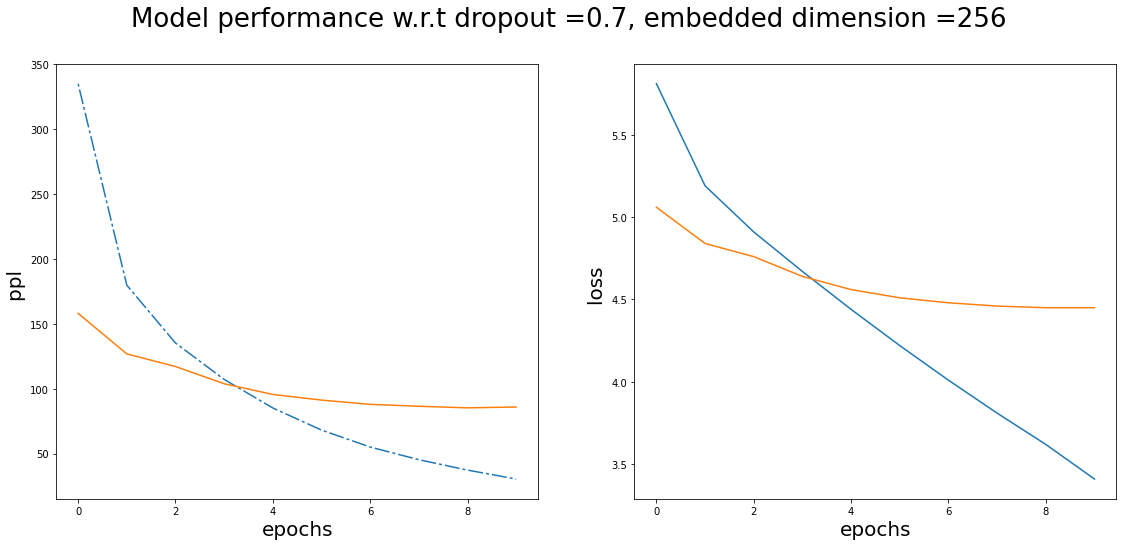

30.36 85.89 3.41 4.45


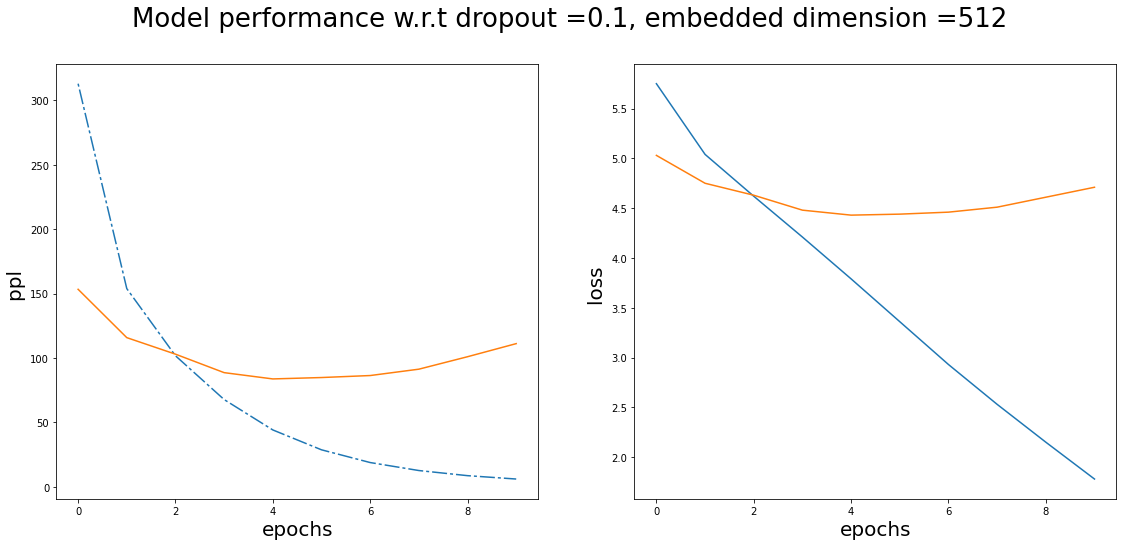

5.96 111.1 1.78 4.71


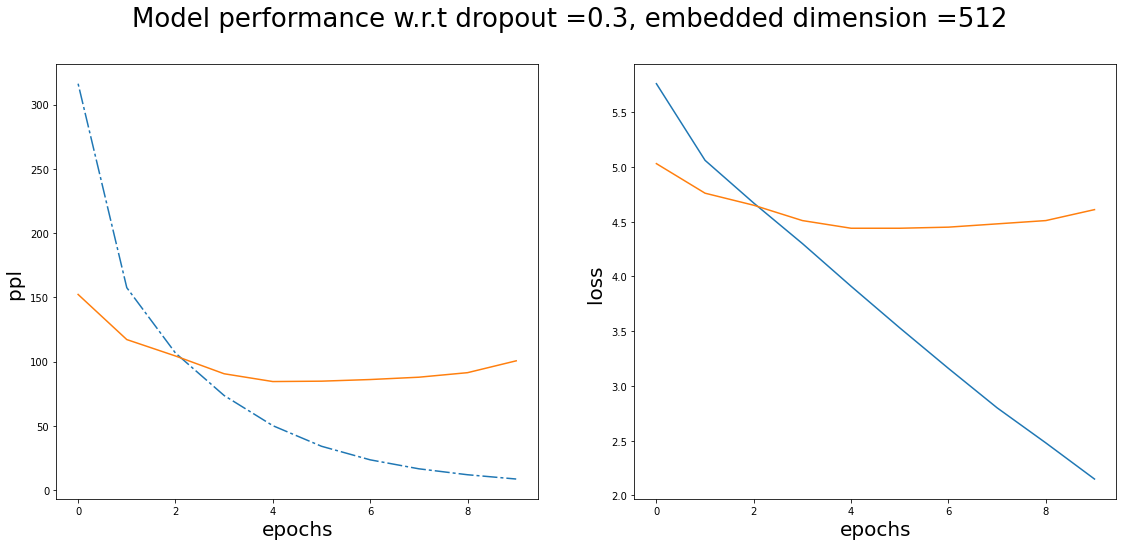

8.56 100.55 2.15 4.61


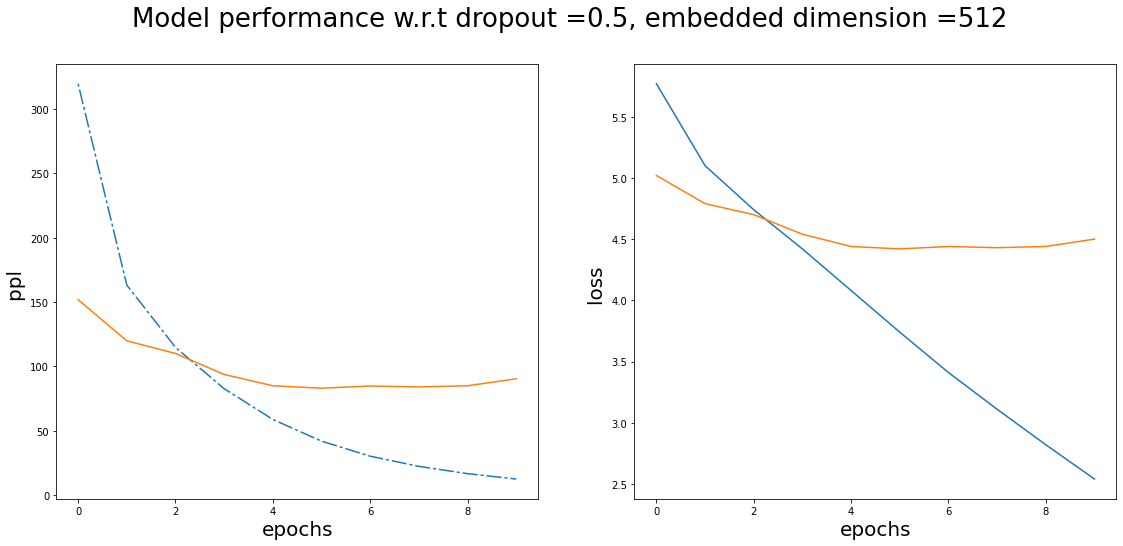

12.66 90.47 2.54 4.5


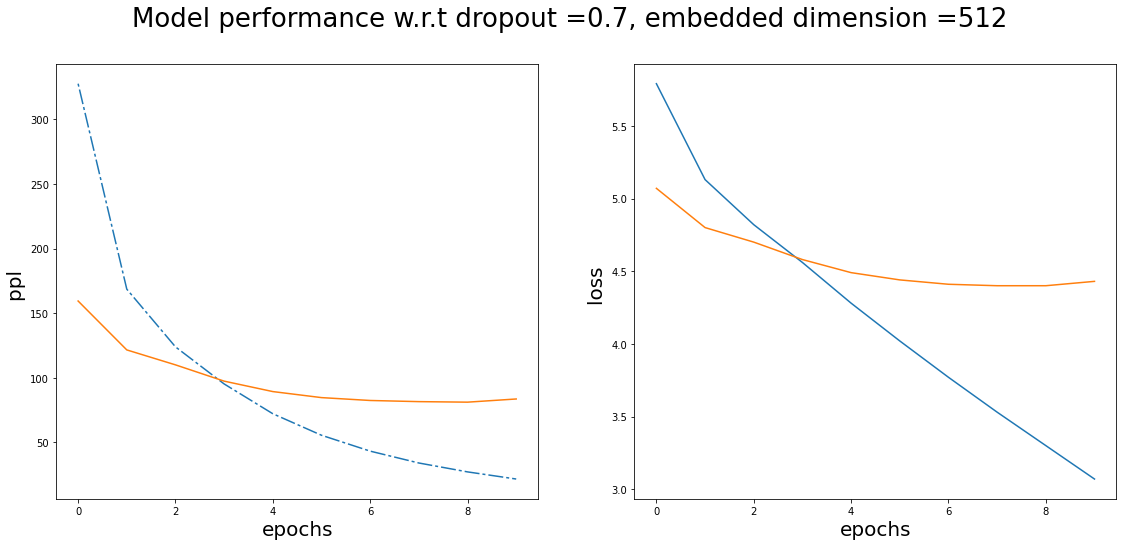

21.64 83.59 3.07 4.43


In [ ]:
def plotmodelperformance(data):

  for i in range(len(data)):

    my1 = data[i]['trainAccyList']
    my2 = data[i]['valAccyList']
    my3 = data[i]['trainLossList']
    my4 = data[i]['valLossList']
    mx = np.arange(len(my1))
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.suptitle('Model performance w.r.t dropout ='+str(data[i]['dropout']) + ', embedded dimension =' + str(data[i]['embeddeddim']), fontsize=26)
    fig.set_figwidth(19)
    #fig.tight_layout(pad = 2.0)

    line1, = ax1.plot(mx, my1, label='trng accy')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line2, = ax1.plot(mx, my2 , label='val accy')

    line3, = ax2.plot(mx, my3, label='trng loss')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break

    # Using plot(..., dashes=...) to set the dashing when creating a line
    line4, = ax2.plot(mx, my4 , label='val loss')

    #ax1.title("model performance", fontsize=16, fontweight='bold')
    ax1.set_xlabel("epochs" , fontsize=20)
    ax1.set_ylabel("ppl " , fontsize=20)
    ax2.set_xlabel("epochs" , fontsize=20)
    ax2.set_ylabel("loss " , fontsize=20)
    #ax.legend()
    plt.show()
    print(my1[-1] , my2[-1], my3[-1] , my4[-1])
plotmodelperformance(data)

# Summary

1.   Training ppl is between 6 to 30 for different dropout values
2.   Validation ppl is between 83 to 111 for different dropout values, but at higher dropout value the ppl decrease at a slower rate , and at dropout value of 0.1 and 0.3 the ppl tends to increase after 10 epochs
3.   Training loss is between 1.7 to 3.5 and decreases at a lower rate after 10 epochs
4.   Validation loss around 4.5 , it tends to increase at dropout value of 0.1 and 0.3 after 10 epochs.

This time dropout did show a difference in model performance , at 0.5 and 0.7 the model is more robust.
Number of embedded dimension did not have any impact across different dropout values.

